In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm

# Lab 8 -- Data Augmentation and Slice Sampling

## Data Augmentation

The term data augmentation refers to methods for constructing iterative algorithms via the introduction of unobserved data or latent variables. For deterministic algorithms, the method was popularized in the general statistical community by the seminal paper of Dempster, Laird, and Rubin (1977) on the EM algorithm for maximizing a likelihood function or more generally a posterior density. For stochastic algorithms, the method was popularized in the statistical literature by Tanner and Wong's (1987) *Data Augmentation algorithm for posterior sampling*, and in the physics literature by Swendsen and Wang's (1987) algorithm for sampling from Ising and Potts models and it generalizations; in the physics literature, the method of data augmentation is referred to as the method of auxiliary variables. Data augmentation schemes were used by Tanner and Wong to make simulation feasible and simple, while auxiliary variables were adopted by Swendsen and Wang to improve the speed of iterative simulation. In general, however, constructing data augmentation schemes that result in both simple and fast algorithms is a matter of art in that successful strategies vary greatly with the observed-data models being considered. 

Lets go back to our usual goal. Find the value of an integral 

$$  I=\int f(x) p(x) dx  $$

(and other integrals that use $p(x)$ as a pdf) which cannot be computed analytically. 

The basic idea is, if it is difficult to simulate from $p(x)$ using the traditional methods we've learned so far, it is often possible to find a joint pdf 
that:

$$ \int p(x,y)\, dy = p(x)  $$

and simulating from the associated conditional pdfs, $p(x|y)$ and $p(y|x)$ is easy.

The DA algorithm is based on this joint pdf, and we *marginalize* over the **augmenting variable** $y$ to obtain samples for $p(x)$.

The first property allows for a construction of Markov chain (see below for the proof). 


The simplest form of DA algorithm takes the following form:

1. Draw $Y\sim p_{Y|X}(.|x)$ and call the observed value y
2. Draw $X_{n+1} \sim p_{X|Y}(.|y)$  

The genesis of the name data augmentation algorithm appears to be Tanner and Wong
(1987) who used it to describe an iterative algorithm for approximating complex posterior
distributions. However, it does not appear to be the case
that Tanner and Wong (1987) ''invented'' the DA algorithm (as I have defined it here), since other researchers, such as Swendsen and Wang (1987) were using it at about the same time. 

Lets do one simple examples and then show the proof of Markov chain. 

### Example 1

Suppose $p(x) = 3\,x^2$ from $0< x < 1$. We take $p(x,y) = 3x$  for 
$y < x < 1$ and $0 < y < x$ then the x-marginal is $p_X(x)=3x^2$. The two conditional densities are given by 

$$ p(y|x)  = \frac{1}{x}  \, \, \, \rm{for} \,\,\, 0 < y < x $$  
and 
$$ p(x|y)  = \frac{2x}{1-y^2}  \, \, \, \rm{for} \,\,\,y < x < 1 $$ 

Simulating from these conditionals is straightforward using inverse transformations. 

$$ Y|X = x  \,\, \sim x \, U $$ 

$$ X|Y = y  \,\, \sim \sqrt{ ( 1-y^2)\,U+y^2} $$

In [26]:
N=100000
x=np.zeros(N)
y=np.zeros(N)
x[0] = 0.1*np.random.rand()  #initial
for i in np.arange(1,N):
    y[i]=x[i-1]*np.random.rand()
    x[i]=np.sqrt((1-y[i]**2)*np.random.rand() + y[i]**2)

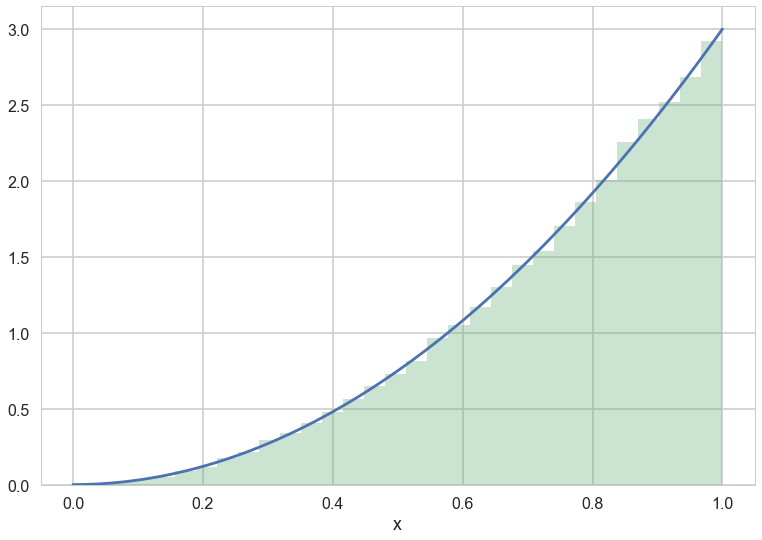

In [27]:
f = lambda xx: 3*xx**2
xxx = np.linspace(0.,1.,100)

plt.plot(xxx, f(xxx))
plt.hist(x, bins=30, alpha=0.3, normed=True);
plt.xlabel('x')

### Example 2

Suppose that $p(x)$ is a Student's t density with 4 degrees of freedom
$$ p(x) = \frac{3}{8} ( 1+ \frac{x^2}{4})^{-5/2} $$

If we take 

$$ p(x,y) = \frac{4}{\sqrt{2\pi}} y^{3/2} \exp{ \left\{  -y \left( \frac{x^2}{2}+2\right) \right\} } $$

for $0 < y < \infty$, 
then we can show that 

$$X|Y = y \,\,  \sim N(0, 1/y) $$ and that 
$$Y|X = x \,\, \sim \rm{Gamma}(5/2, x^2/2+2)$$



In [30]:
#We leave the implementation of this as an exercise

## Slice Sampling

We've already studied two MCMC variants, Gibbs Sampling and Metropolis-Hastings.  These are the foundational (and in many senses, original) MCMC methods.  Both methods are based on random walk Markov Chains.  You may have started to notice, or at least suspect, that there are many situation in which we want greater flexibity in exploring the probability space than waht a random walk Markov Chain provides.  There are a variety of MCMC methods that offer different approaches to traversing the distribution than Metropolis-Hastings (or Gibbs Sampling which is after all a type of Metropolis-Hastings).  We'll explore a number of these methods over the next few weeks.  

One of the methods that we'll look at is Slice Sampling.  Slice sampling was invented by Radfor Neal and John Skilling.  It is a very elegant and simple way to solve the problems of MH and Gibbs sampling. So easy, that you would think my grandmother invented it. Slice Sampling is geared to approach the following problem with Methropolis-Hastings.  Metropolis Hastings is very sensitive to the width of the proposal step.  You can tune the Metropolis-Hastings algorithm by choosing a proposal in such a way as to determine the width of the proposal distribution for each variable.  Unfortunately satisfying detailed-balance provides a constraint preventing any proposal width scale parameters from being set based on past iterations of the current chain.

One can set the proposal distribution width based on prior knowledge (usually done by running trial chains), but will often be confronted with the choice between a large width that explores the space efficiently but results in many rejections or a small proposal width that has a low rejection rate but explores the parameter space inefficiently. We usually want the width (aka step) to be as large as possible but not that large. Gibbs sampling does not have those parameters and therefore we may like it, but it only works when we know the conditional distribution. 






## How does slice sampling work?

If you recall from Data Augmentation, if we have a posterior distribution (i.e.  X ~ p(x) ) from which we're trying to sample, we can augment that distribution with additional variables to create a joint distribution p(x,y) with conditional distributions Y|X and X|Y that are easy to sample from.  We can use Gibbs to sample from these conditional distributions and keep the X samples while eventually discarding the Y samples that we don't need.

Slice sampling takes advantage of this same methodology to to try to efficiently sample from a distribution while dynamically adapting step-size to the local region it's sampling.  Let's take a look how.

### The Univariate Slice Sampling Algorithm

With all that background, our univariate slice sampling algorithm should be clear

* Pick an initial point $ x_0 $ from our posterior
* Draw $ y_0 $ from U(0, f($x_0$))
* Repeat for N samples
  * Select the interval (e.g. doubling, stepping out, etc)
  * Sample $ x_i $ from that interval (e.g. shrinkage)
  * Draw $ y_i $ from U(0, f($x_i$))

## Revisiting Data Augmentation

Let's look a bit more closely at Data Augmentation and it's relationship to Slice Sampling.  If you recall the exact procedure for data augmentation is as follows. 

You're given $ X $ from which you wish to sample.  Sampling from them is difficult but with the addition of some auxilliary variables $ Y $ you're able to sample from the joint probability p(X,Y) so that :

1.  the conditionals X|Y and Y|X are easy to sample 
2.  the marginal p(X) from the joint p(X,Y) matches your target distribution.
3.  You can then use Gibbs Sampling to generate samples for the joint distribution and keep the X samples 


Now let's look more closely at our slice sampling procedure.  

* We're given X
* We add an auxiliary variable Y 
* The marginals are easy to sample
   * Y|X ~ Unif(0,f(x))
   * X|Y = 1 if f(x) > y and 0 otherwise
* the marginal of X matches our target distribution by construction
* we use Gibbs sampling to generate our samples

IT's A DATA AUGMENTATION PROCEDURE!  The only difference is that we don't explicitly know our joint distribution.



## Multivariate Slice Sampling

On casual inspection it would seem that the slice sampling algorithm would generalize very easily to the multivariate case.  If we look at our general univariate algorithm:

0. Inititalize by randomly selecting $x^{(0)}$
1. Draw $y^{(k)} $ from $ U(0, f(x^{(k)})) $
2. Find an interval I = (L, R) around $ x^{k} $ corresponding to $ S = \{x\, s.t.\,  f(x) > f(x^{k}) \} $
3. Draw $ x^{k+1} $ from U(I)


A natural extension to $ R^n $ would be:

0. Inititalize by randomly selecting $\hat{x}^{(0)}$
1. Draw $y^{(k)} $ from $ U(0, f(x^{(k)})) $
2. Find a hyperrectangle K = $\{(L_1,R_1)\times \ldots \times(L_n, R_n)\}$ around $ \hat{x}^{k} $ corresponding to $ S = \{\hat{x}\, s.t.\,  f(\hat{x}) > f(\hat{x}^{k}) \} $
3. Draw $ \hat{x}^{k+1} $ uniformly from K

Step 1 is not difficult and generalizes easily.  Step 2 is difficult.  We ideally want the minimum hyperrectangle containing $ S $, but in practice this is just as (if not more) difficult as finding the ideal interval $I$ in the univariate case.  Moreover some of the techniques that we described in the univariate case have difficulties in the multivariate case.

* Stepping out is difficult because an $n$ dimensional hyperrectangle has $ 2^n $ vertices.  Checking individual vertices can be a computationally expensive problem.  In addition, stepping out individually in $n$ directions can be computationally expensive as well.

* Accept/reject on a global region (in the case where your distribution is bounded) is even less efficient in multiple dimensions than it is in one.

We outline a simple solution that gives up some of the natural advantages of univariate slice sampling but does solve some of the basic issues for multivariate slice sampling.  It depends on having some prior knowledge of the appropriate hyperectagle width in each dimension.

#### Hyperrectangle multivariate slices sample algorithm

* start with $ x^{k} $ and $\hat{w} $ -- the prior widths
* $ y^{k} \sim Unif(0,f(x^{k})) $
* for $ i = 1 \ldots n $ (setting hyperrectangle around $ x^{k} $)
   * $ u_i \sim Unif(0,1) $
   * $ L_i = x^{k}_i - w_i u_i $
   * $ R_i = L_i + w_i $
* loop until:
   * for $ i = 1 \ldots n $ 
      * $ u_i \sim Unif(0,1) $
      * $ x^{*}_i = Unif(L_i, R_i) $
   * if $y^{(k)}< f(x^{*})$
      * accept x* and end loop
   * else
      * for $ i = 1 \ldots n$
         * if $x^{*}_i <  x^{(k)}_i \rightarrow  L_i = x^{*}_i$ 
         * if $x^{*}_i > x^{(k)}_i \rightarrow  R_i = x^{*}_i$
         

It should be noted that because we don't use a method like doubling or setting out, we gain an increased sensitivity to step-size (via our dependence on the width vector $ \hat{w} $ and lose part of the advantage slice sampling held over Metropolis-Hastings.  Width is now a tunable parameter.

In [29]:
def clike2(value):
    x = value[0]
    y = value[1]
    val = -100 * (T.sqrt(y**2+x**2)-1)**2 + (x-1)**3 - y -5
    return (val)

In [4]:
with pm.Model() as model:
    banana = pm.DensityDist("banana", clike2, shape=2, testval=[1,1])

In [5]:
with model:
    start = pm.find_MAP()
    stepper=pm.Metropolis()
    trace=pm.sample(100000, step=stepper)

Optimization terminated successfully.
         Current function value: 4.252150
         Iterations: 24
         Function evaluations: 33
         Gradient evaluations: 33


100%|██████████| 100000/100000 [00:17<00:00, 5606.63it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1107ba990>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11099e7d0>]], dtype=object)

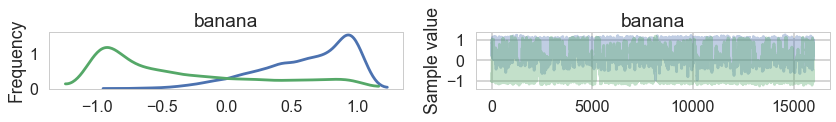

In [6]:
pm.traceplot(trace[20000::5])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1251c5c88>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x128140908>]], dtype=object)

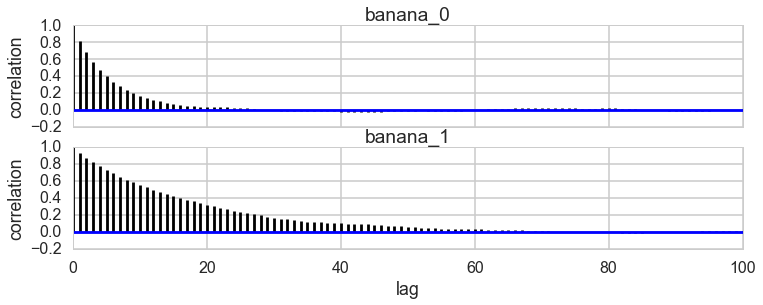

In [44]:
pm.autocorrplot(trace[20000::5])

In [7]:
with model:
    start_slice = pm.find_MAP()
    stepper_slice=pm.Slice()
    trace_slice=pm.sample(100000, step=stepper_slice)

  0%|          | 156/100000 [00:00<01:04, 1549.01it/s]

Optimization terminated successfully.
         Current function value: 4.252150
         Iterations: 24
         Function evaluations: 33
         Gradient evaluations: 33


100%|██████████| 100000/100000 [01:39<00:00, 1005.43it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1106e5890>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1106e9690>]], dtype=object)

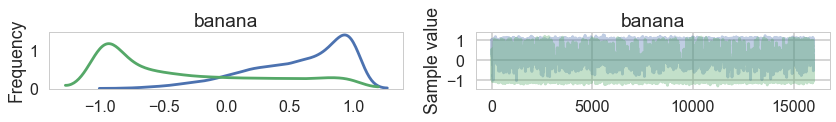

In [8]:
pm.traceplot(trace_slice[20000::5])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1283d6ba8>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x128974630>]], dtype=object)

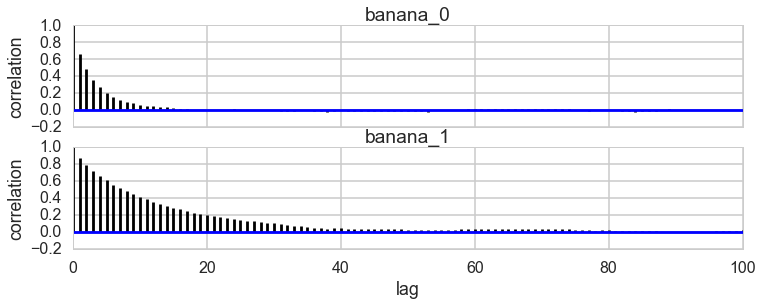

In [46]:
pm.autocorrplot(trace_slice[20000::5])

In [9]:
with model:
    start_nuts = pm.find_MAP()
    stepper_nuts=pm.NUTS()
    trace_nuts=pm.sample(100000, step=stepper_nuts)

Optimization terminated successfully.
         Current function value: 4.252150
         Iterations: 24
         Function evaluations: 33
         Gradient evaluations: 33


100%|██████████| 100000/100000 [02:10<00:00, 765.20it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x129b6c198>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x129beef98>]], dtype=object)

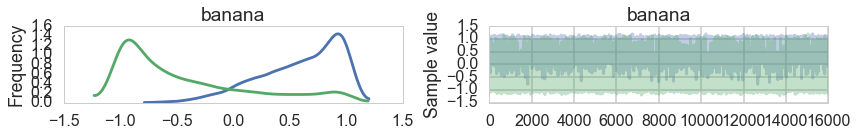

In [52]:
pm.traceplot(trace_nuts[:16000])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1290e0048>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x129fe0da0>]], dtype=object)

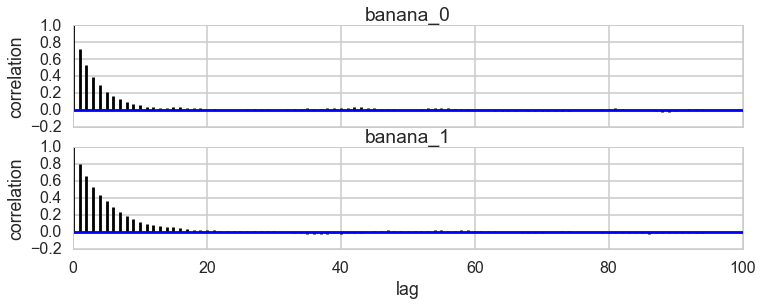

In [53]:
pm.autocorrplot(trace_nuts[:16000])

In [10]:
def compute_sigma_level(trace1, trace2, nbins=20):
    """From a set of traces, bin by number of standard deviations"""
    L, xbins, ybins = np.histogram2d(trace1, trace2, nbins)
    L[L == 0] = 1E-16
    logL = np.log(L)

    shape = L.shape
    L = L.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)

    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]
    
    xbins = 0.5 * (xbins[1:] + xbins[:-1])
    ybins = 0.5 * (ybins[1:] + ybins[:-1])

    return xbins, ybins, L_cumsum[i_unsort].reshape(shape)

def plot_MCMC_trace(ax, trace1, trace2, scatter=False, **kwargs):
    """Plot traces and contours"""
    xbins, ybins, sigma = compute_sigma_level(trace1, trace2)
    ax.contour(xbins, ybins, sigma.T, levels=[0.683, 0.955], **kwargs)
    if scatter:
        ax.plot(trace1, trace2, ',k', alpha=0.1)
    ax.set_xlabel(r'x')
    ax.set_ylabel(r'y')

In [11]:
xtrace = trace_nuts['banana'][:,0]
ytrace = trace_nuts['banana'][:,1]

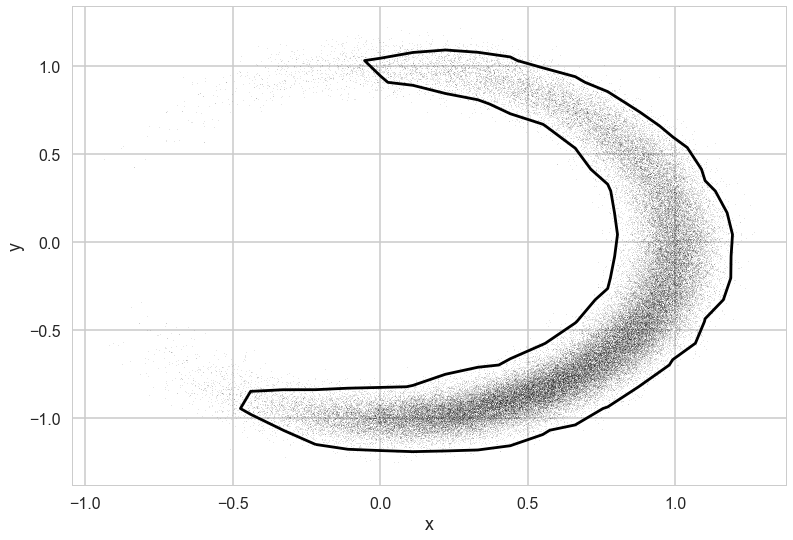

In [12]:
ax=plt.gca()
plot_MCMC_trace(ax, xtrace, ytrace, True)

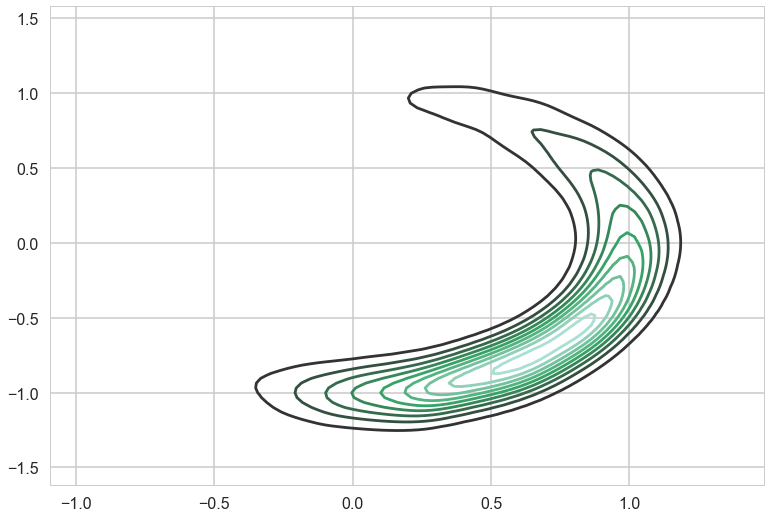

In [13]:
sns.kdeplot(trace_nurs['banana'][:16000])

In [20]:
# define the pdf
func = lambda x,y: np.exp(-100 * (np.sqrt(y**2+x**2)-1)**2 + (x-1)**3 - y -5)

In [31]:
# slice sampling
def multi_slice_sampling(niter,pdf,x0,widths,dims=2):

    # initialize the sampler
    y0 = np.random.uniform(low=0,high=pdf(x0[0],x0[1]))
    samples = []

    # a hyperrectangle around the original point
    rectUnifs = np.random.uniform(size=dims)
    rectLefts = x0 - widths*rectUnifs
    rectRights = rectLefts + widths

#----------------------------------------------------------------------------------
    # do the sampling
    for i in range(niter):
        while (True):
            # new proposal
            xstarUnifs = np.random.uniform(size=dims)
            xstar = rectLefts + xstarUnifs*(rectRights - rectLefts)

            # loop until we find the point inside the region
            if y0 < pdf(xstar[0],xstar[1]):
                break
            else:
                # shrink rectangle to  make the search faster
                for j in range(dims):
                    if xstar[j] < x0[j]:
                        rectLefts[j] = xstar[j]
                    else:
                        rectRights[j] = xstar[j]
                
#--------------------------------------------------------------------------------------
        # save the current sample
        samples.append(xstar)

        # the last sample is now the proposal
        x0 = xstar

        # get the new y0 for next step
        y0 = np.random.uniform(low=0, high=pdf(x0[0],x0[1]))

        # reset the rectangle
        rectUnifs = np.random.uniform(size=dims)
        rectLefts = x0 - widths*rectUnifs
        rectRights = rectLefts + widths

#--------------------------------------------------------------------------------------
    # extract x-samples and y-samples
    x_samples = [s[0] for s in samples]
    y_samples = [s[1] for s in samples]
    
    x_samples = np.array(x_samples)
    y_samples = np.array(y_samples)
    
    return x_samples, y_samples

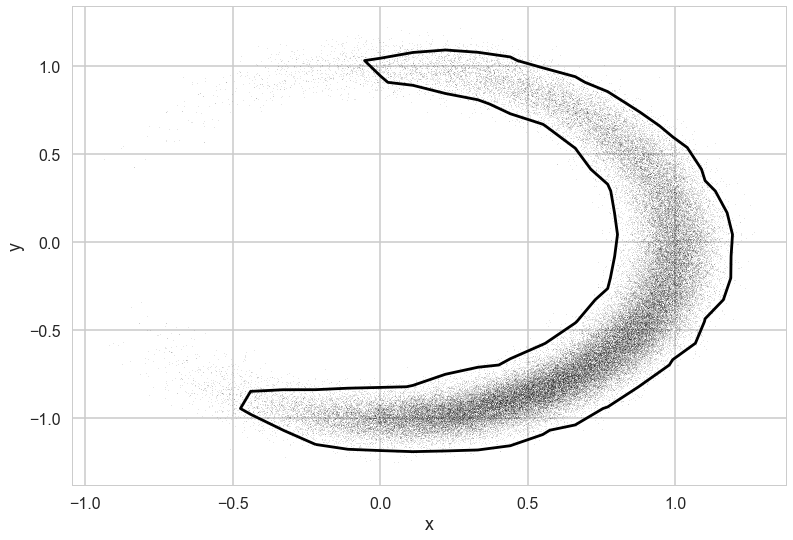

In [32]:
# perform slice sampling
x_samples, y_samples = multi_slice_sampling(100000,func,[1,0],[1.0,1.0])

ax=plt.gca()
plot_MCMC_trace(ax, xtrace, ytrace, True)